# DistilBERT fine-tuning for ADE classification

**Goal.** Fine-tune DistilBERT on the cleaned splits, choose a threshold on validation with a recall target, and evaluate on test.


In [ ]:
from pathlib import Path
import os, sys, json, random, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import inspect

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    precision_recall_curve, roc_curve, auc,
    average_precision_score, roc_auc_score,
    brier_score_loss, confusion_matrix
)
from sklearn.calibration import calibration_curve

from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check the Drive path."
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import importlib, src; importlib.reload(src)

from src import (
    set_seed, ensure_dir, choose_text_col, compute_class_weights, save_json,
    plot_confusion, pick_thr_with_recall_floor
)
from src.hf_utils import token_length_stats, make_hf_datasets, WeightedTrainer

# dirs + seed
ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
TRANS_DIR     = ensure_dir(ARTIFACTS_DIR / "transformers" / "distilbert")
set_seed(42)
plt.rcParams["figure.dpi"] = 150

Mounted at /content/drive


# **Load data**

In [ ]:
train_df = pd.read_csv(ARTIFACTS_DIR / "train_clean.csv")
val_df   = pd.read_csv(ARTIFACTS_DIR / "val_clean.csv")
test_df  = pd.read_csv(ARTIFACTS_DIR / "test_clean.csv")

TEXT_COL  = choose_text_col(train_df, "text_clean")
LABEL_COL = "label"

for df, name in [(train_df,"train"), (val_df,"val"), (test_df,"test")]:
    assert {TEXT_COL, LABEL_COL}.issubset(df.columns), f"{name} missing columns"
    if "uid" not in df.columns:
        df["uid"] = [f"{name[:2]}_{i:05d}" for i in range(len(df))]

print({"train": train_df.shape, "val": val_df.shape, "test": test_df.shape, "text_col": TEXT_COL})

{'train': (13743, 7), 'val': (1527, 7), 'test': (5626, 7), 'text_col': 'text_clean'}


# **Tokenizer, token lengths, datasets**

## Token length check
- compute token length statistics on the training text using the fast tokenizer.
- Percentiles guide `MAX_LEN`; set `MAX_LEN = 320` to cover almost all cases.
- This keeps truncation minimal and batch sizes practical.


In [ ]:
distil_tok = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# fast token-length stats via src.hf_utils (returns max, mean, q95, q99)
stats = token_length_stats(distil_tok, train_df[TEXT_COL])
p95_tok, p99_tok = stats["q95"], stats["q99"]

MAX_LEN = 320
print(f"token length p95={p95_tok}, p99={p99_tok} | using MAX_LEN={MAX_LEN}")

# build encoded datasets with src helper
ds_train, ds_val, ds_test, d_collator = make_hf_datasets(
    train_df, val_df, test_df, text_col=TEXT_COL, tokenizer=distil_tok, max_len=MAX_LEN
)
pad8 = 8 if torch.cuda.is_available() else None  # dataCollator
print(f"datasets: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

token length p95=55, p99=74 | using MAX_LEN=320
datasets: train=13743, val=1527, test=5626


# **Training args + metrics (and WeightedTrainer)**

## Training setup
- Loss uses class weights to address imbalance.
- Early stopping is enabled with patience two and the best model is restored at the end.
- Training arguments use a fixed seed, weight decay, warmup steps, and a learning rate of five times ten to the minus five.
- Metrics reported during training include accuracy, precision, recall, F1, PR-AUC, and ROC-AUC.


In [ ]:
cw = compute_class_weights(train_df[LABEL_COL])  # [w0, w1]

def compute_metrics(eval_pred):
    # supports both tuple and EvalPrediction
    if hasattr(eval_pred, "predictions"):
        logits, labels = eval_pred.predictions, eval_pred.label_ids
    else:
        logits, labels = eval_pred

    if isinstance(logits, tuple):
        logits = logits[0]

    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    y_pred = np.asarray(logits).argmax(-1)

    p, r, f1, _ = precision_recall_fscore_support(labels, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(labels, y_pred)
    ap  = average_precision_score(labels, probs)
    ra  = roc_auc_score(labels, probs)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r, "pr_auc": ap, "roc_auc": ra}


# version-safe TrainingArguments
def build_targs(**kw):
    sig = inspect.signature(TrainingArguments.__init__).parameters
    out = dict(
        output_dir=kw.get("output_dir"),
        num_train_epochs=kw.get("num_train_epochs", 10),
        per_device_train_batch_size=kw.get("per_device_train_batch_size", 16),
        per_device_eval_batch_size=kw.get("per_device_eval_batch_size", 64),
        logging_dir=kw.get("logging_dir"),
        logging_steps=50,
        report_to="none",
        warmup_steps=200,
        weight_decay=0.01,
        save_total_limit=2,
        seed=kw.get("seed", 42),
        fp16=kw.get("fp16", torch.cuda.is_available()),
        learning_rate=kw.get("learning_rate", 5e-5),
    )
    if "evaluation_strategy" in sig: out["evaluation_strategy"] = "epoch"
    elif "eval_strategy" in sig:     out["eval_strategy"] = "epoch"
    if "save_strategy" in sig:             out["save_strategy"] = "epoch"
    if "load_best_model_at_end" in sig:    out["load_best_model_at_end"] = True
    if "metric_for_best_model" in sig:     out["metric_for_best_model"]  = kw.get("select_metric", "eval_recall")
    if "greater_is_better" in sig:         out["greater_is_better"]      = kw.get("greater_is_better", True)
    return TrainingArguments(**out)

distil_args = build_targs(
    output_dir=str(TRANS_DIR / "results"),
    logging_dir=str(TRANS_DIR / "logs"),
    num_train_epochs=10,
    seed=42,
    select_metric="eval_recall",
    greater_is_better=True,
    learning_rate=5e-5)

# amend src WeightedTrainer to take new HF kwargs (e.g., num_items_in_batch)
class PatchedWeightedTrainer(WeightedTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = getattr(outputs, "logits", outputs[0])
        if labels.dtype != torch.long:
            labels = labels.long()

        weight = getattr(self, "class_weights", None)
        if weight is not None:
            weight = weight.to(logits.device)

        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


distil_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

distil_trainer = PatchedWeightedTrainer(
    model=distil_model,
    args=distil_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=d_collator,
    tokenizer=distil_tok,# FutureWarning
    compute_metrics=compute_metrics,
    class_weights=torch.tensor(cw, dtype=torch.float), )

distil_trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

_ = distil_trainer.train()
print("best_checkpoint:", distil_trainer.state.best_model_checkpoint)
print("best eval_recall:", distil_trainer.state.best_metric)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/src/hf_utils.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PatchedWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/src/hf_utils.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Pr Auc,Roc Auc
1,0.280600,0.229860,0.935167,0.833613,0.797428,0.873239,0.906929,0.973172
2,0.246700,0.242666,0.928618,0.825600,0.756598,0.908451,0.901197,0.975246
3,0.137900,0.471121,0.938441,0.835088,0.832168,0.838028,0.883562,0.969607
4,0.103800,0.515984,0.934512,0.830508,0.800654,0.862676,0.896985,0.968296


best_checkpoint: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/results/checkpoint-1718
best eval_recall: 0.9084507042253521


# **Validation & Test probabilities + Threshold tuning**

## Validation threshold policy
- select the operating point on validation using a recall floor of 0.90.
- Among thresholds that meet the floor, we choose the one with the highest precision and break ties with F1.
- The chosen threshold is saved to `artifacts/transformers/distilbert/thresholds.json`.


In [ ]:
# helper to get probs/labels from trainer
def get_labels_probs(trainer, dataset):
    out = trainer.predict(dataset)
    logits = out.predictions if not isinstance(out.predictions, tuple) else out.predictions[0]
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    return out.label_ids, probs

d_val_y,  d_val_p  = get_labels_probs(distil_trainer, ds_val)
d_test_y, d_test_p = get_labels_probs(distil_trainer, ds_test)

RECALL_FLOOR = 0.90
tv_best_thr, stats = pick_thr_with_recall_floor(d_val_y, d_val_p, floor=RECALL_FLOOR)

print("VAL threshold:", f"{tv_best_thr:.3f}")
print("VAL metrics at chosen threshold:",
      f"Precision={stats['precision']:.3f} | Recall={stats['recall']:.3f} | F1={stats['f1']:.3f} | PR-AUC={stats['pr_auc']:.3f}")


VAL threshold: 0.548
VAL metrics at chosen threshold: Precision=0.769 | Recall=0.905 | F1=0.832 | PR-AUC=0.901


# **Save artifacts (model, tokenizer, preds, thresholds, metrics)**

In [ ]:
MODEL_DIR = ensure_dir(TRANS_DIR / "model")
PRED_DIR  = ensure_dir(TRANS_DIR / "preds")

# model + tokenizer
distil_trainer.model.save_pretrained(MODEL_DIR)
distil_tok.save_pretrained(MODEL_DIR)

# stable IDs
va_ids = val_df["uid"].astype(str).values
te_ids = test_df["uid"].astype(str).values

pd.DataFrame({"id": va_ids, "y_true": d_val_y,  "y_score": d_val_p}).to_csv(PRED_DIR/"val_probs.csv",  index=False)
pd.DataFrame({"id": te_ids, "y_true": d_test_y, "y_score": d_test_p}).to_csv(PRED_DIR/"test_probs.csv", index=False)

# PR-AUCs
def pr_auc(y,p):
    pr_p, pr_r, _ = precision_recall_curve(y,p); return float(auc(pr_r, pr_p))
val_ap  = pr_auc(d_val_y, d_val_p)
test_ap = pr_auc(d_test_y, d_test_p)

# TEST at VAL-chosen threshold
d_test_hat = (d_test_p >= tv_best_thr).astype(int)
tP, tR, tF1, _ = precision_recall_fscore_support(d_test_y, d_test_hat, average="binary", zero_division=0)
tAcc = accuracy_score(d_test_y, d_test_hat)

save_json({"strategy":"recall_floor","floor":float(RECALL_FLOOR),
           "best_threshold":float(tv_best_thr)}, TRANS_DIR/"thresholds.json")

save_json({"pr_auc": val_ap,
           "val_at_best": {"precision": float(stats["precision"]), "recall": float(stats["recall"]),
                           "f1": float(stats["f1"]), "thr": float(tv_best_thr)}},
          TRANS_DIR/"metrics_val.json")

save_json({"threshold": float(tv_best_thr), "precision": float(tP), "recall": float(tR),
           "f1": float(tF1), "accuracy": float(tAcc), "pr_auc": float(test_ap)},
          TRANS_DIR/"metrics_test.json")

print("Saved:", {"model_dir": str(MODEL_DIR),
                "preds": [str(PRED_DIR/'val_probs.csv'), str(PRED_DIR/'test_probs.csv')],
                "thresholds": str(TRANS_DIR/'thresholds.json')})

Saved: {'model_dir': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/model', 'preds': ['/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/preds/val_probs.csv', '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/preds/test_probs.csv'], 'thresholds': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/thresholds.json'}


# **PR/ROC Plots (VAL + TEST)**

## Evaluation on validation and test
- compute probabilities on validation and test and report PR-AUC and ROC-AUC.
- The test confusion matrix is computed at the validation-chosen threshold.
- PR and ROC grids for both splits help judge ranking quality independent of a single threshold.


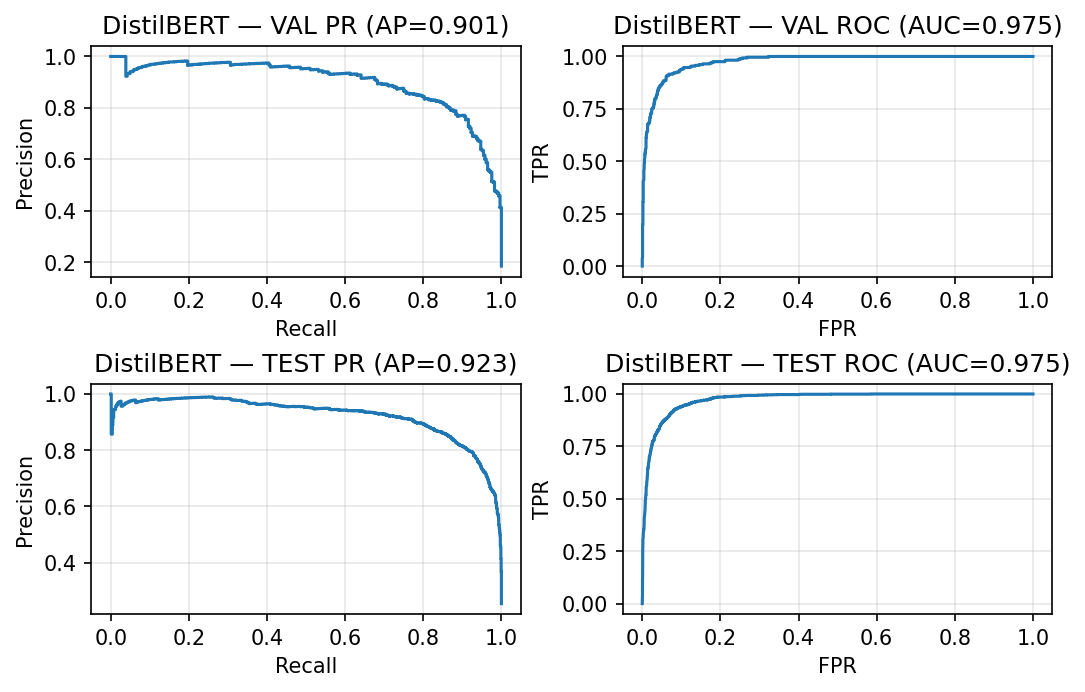

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/distil_val_test_pr_roc_grid.png


In [ ]:
def plot_val_test_grid(y_va, p_va, y_te, p_te, model_name: str, out_png: Path):
    pr_p_va, pr_r_va, _ = precision_recall_curve(y_va, p_va)
    fpr_va, tpr_va, _   = roc_curve(y_va, p_va)
    pr_p_te, pr_r_te, _ = precision_recall_curve(y_te, p_te)
    fpr_te, tpr_te, _   = roc_curve(y_te, p_te)

    ap_va  = average_precision_score(y_va, p_va)
    ap_te  = average_precision_score(y_te, p_te)
    auc_va = auc(fpr_va, tpr_va)
    auc_te = auc(fpr_te, tpr_te)

    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), constrained_layout=True)

    ax = axes[0,0]; ax.step(pr_r_va, pr_p_va, where="post")
    ax.set_title(f"{model_name} — VAL PR (AP={ap_va:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[0,1]; ax.plot(fpr_va, tpr_va)
    ax.set_title(f"{model_name} — VAL ROC (AUC={auc_va:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    ax = axes[1,0]; ax.step(pr_r_te, pr_p_te, where="post")
    ax.set_title(f"{model_name} — TEST PR (AP={ap_te:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[1,1]; ax.plot(fpr_te, tpr_te)
    ax.set_title(f"{model_name} — TEST ROC (AUC={auc_te:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

plot_val_test_grid(d_val_y, d_val_p, d_test_y, d_test_p,
                   "DistilBERT", PLOTS_DIR / "distil_val_test_pr_roc_grid.png")


Validation PR AUC is 0.901 and validation ROC AUC is 0.975.

Test PR AUC is 0.923 and test ROC AUC is 0.975.

Curves are tight and stable from validation to test, which points to limited overfitting.

Ranking quality is clearly stronger than the TF-IDF baselines.

# **Confusion Matrix (TEST at VAL-chosen threshold)**

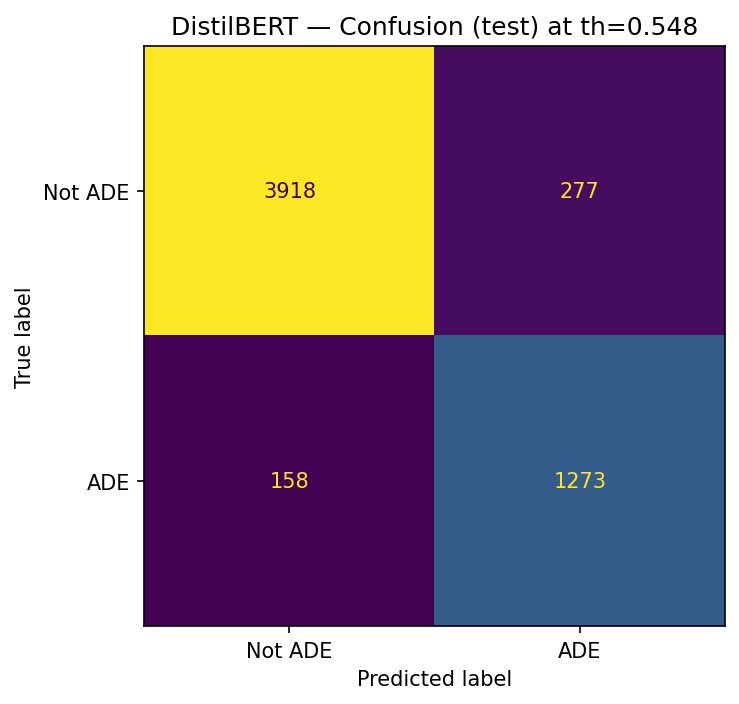

TN, FP, FN, TP = 3918 277 158 1273
Precision=0.821 | Recall=0.890 | F1=0.854 | Accuracy=0.923
Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/distil_test_confusion.png


In [ ]:
y_hat = (d_test_p >= tv_best_thr).astype(int)
cm = confusion_matrix(d_test_y, y_hat, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec = tp / (tp + fp + 1e-12)
rec  = tp / (tp + fn + 1e-12)
f1   = 2 * prec * rec / (prec + rec + 1e-12)
acc  = (tp + tn) / cm.sum()

out_cm = PLOTS_DIR / "distil_test_confusion.png"
plot_confusion(d_test_y, y_hat, out_cm, title=f"DistilBERT — Confusion (test) at th={tv_best_thr:.3f}")

print("TN, FP, FN, TP =", tn, fp, fn, tp)
print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | Accuracy={acc:.3f}")
print("Saved:", out_cm)

True negatives 3918, false positives 277, false negatives 158, true positives 1273.

Precision 0.821, recall 0.890, F1 0.854, accuracy 0.923.

Recall is high with a strong precision level.

This operating point finds most ADE cases while controlling false positives.

# **Thresholds at recall targets (VAL)**

In [ ]:
def thr_at_recall(y, s, target):
    p, r, t = precision_recall_curve(y, s)
    idx = np.where(r >= float(target))[0]
    if len(idx) == 0: return None
    i = idx[-1]
    thr = 0.5 if i == 0 else float(t[i-1])
    return thr, float(p[i]), float(r[i])

for tgt in [0.80, 0.85, 0.90, 0.92, 0.95]:
    res = thr_at_recall(d_val_y, d_val_p, tgt)
    if res is None:
        print(f"VAL recall>={tgt:.2f}: impossible")
    else:
        thr, P, R = res
        print(f"VAL recall>={tgt:.2f}: thr={thr:.3f}, precision={P:.3f}")


VAL recall>=0.80: thr=0.966, precision=0.844
VAL recall>=0.85: thr=0.890, precision=0.820
VAL recall>=0.90: thr=0.554, precision=0.771
VAL recall>=0.92: thr=0.305, precision=0.722
VAL recall>=0.95: thr=0.119, precision=0.640


# **Calibration (TEST) + Brier**

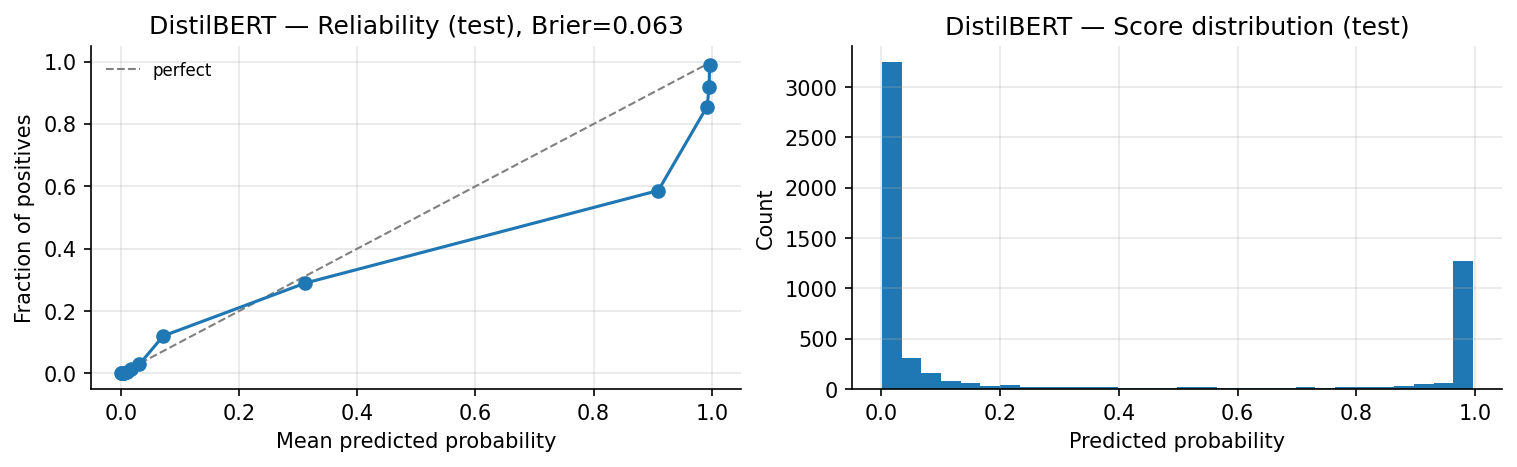

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/distil_test_calib_and_hist.png


In [ ]:
prob_true, prob_pred = calibration_curve(d_test_y, d_test_p, n_bins=15, strategy="quantile")
brier = brier_score_loss(d_test_y, d_test_p)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax = axes[0]
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", label="perfect")
ax.plot(prob_pred, prob_true, marker="o")
ax.set_xlabel("Mean predicted probability"); ax.set_ylabel("Fraction of positives")
ax.set_title(f"DistilBERT — Reliability (test), Brier={brier:.3f}")
ax.grid(alpha=0.3); ax.legend(frameon=False, fontsize=8)
for s in ("top", "right"): ax.spines[s].set_visible(False)

ax = axes[1]
ax.hist(d_test_p, bins=30, histtype="stepfilled")
ax.set_xlabel("Predicted probability"); ax.set_ylabel("Count")
ax.set_title("DistilBERT — Score distribution (test)")
ax.grid(alpha=0.3)
for s in ("top", "right"): ax.spines[s].set_visible(False)

out_fig = PLOTS_DIR / "distil_test_calib_and_hist.png"
fig.savefig(out_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_fig)


Brier score is 0.063.

Reliability curve is close to the diagonal at higher probabilities and slightly under-confident in the middle range.

Score histogram shows clear separation with most non-ADE near zero and many ADE near one.


# **Top FP/FN examples + CSVs**

In [ ]:
ERR_DIR = ensure_dir(TRANS_DIR / "errors")

df = test_df.reset_index(drop=True).copy()
df["y_true"] = d_test_y
df["y_prob"] = d_test_p
df["y_pred"] = (df["y_prob"] >= tv_best_thr).astype(int)
df["err"] = np.where((df["y_true"]==0) & (df["y_pred"]==1), "FP",
              np.where((df["y_true"]==1) & (df["y_pred"]==0), "FN", ""))

id_col = "uid" if "uid" in df.columns else None
cols = ([id_col] if id_col else []) + [TEXT_COL, "y_true", "y_prob", "y_pred", "err"]

fp = (df[df.err=="FP"].sort_values("y_prob", ascending=False)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))
fn = (df[df.err=="FN"].sort_values("y_prob", ascending=True)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))

display(fp[cols + ["text_snip"]].head(10))
display(fn[cols + ["text_snip"]].head(10))

fp_path = ERR_DIR / "distil_test_fp_examples.csv"
fn_path = ERR_DIR / "distil_test_fn_examples.csv"
fp[cols + ["text_snip"]].to_csv(fp_path, index=False)
fn[cols + ["text_snip"]].to_csv(fn_path, index=False)
print("Saved:", fp_path, "|", fn_path)

print("\n#FP examples")
for x in fp[TEXT_COL].head(5): print("-", str(x)[:220])

print("\n#FN examples")
for x in fn[TEXT_COL].head(5): print("-", str(x)[:220])


,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
2156,te_2156,Systemic lupus erythematosus: association with...,0,0.996420,1,FP,Systemic lupus erythematosus: association with...
2343,te_2343,Hypersensitivity reaction to sulindac (Clinoril).,0,0.996329,1,FP,Hypersensitivity reaction to sulindac (Clinoril).
782,te_782,Systemic lupus erythematosus (SLE) developed i...,0,0.996271,1,FP,Systemic lupus erythematosus (SLE) developed i...
44,te_44,Anaphylactic/anaphylactoid reactions to methot...,0,0.996161,1,FP,Anaphylactic/anaphylactoid reactions to methot...
4777,te_4777,Cardiobacterium hominis endocarditis in a pati...,0,0.995930,1,FP,Cardiobacterium hominis endocarditis in a pati...
4542,te_4542,DISCUSSION: CIPS is hypothesized to result fro...,0,0.995922,1,FP,DISCUSSION: CIPS is hypothesized to result fro...
2318,te_2318,Drug eruption associated with sulfonamide trea...,0,0.995858,1,FP,Drug eruption associated with sulfonamide trea...
976,te_976,Stent fracture: an unusual cause of late reste...,0,0.995826,1,FP,Stent fracture: an unusual cause of late reste...
4678,te_4678,Cholestatic hepatitis after administration of ...,0,0.995817,1,FP,Cholestatic hepatitis after administration of ...
47,te_47,Cutaneous adverse reactions to 8-methoxypsoral...,0,0.995809,1,FP,Cutaneous adverse reactions to 8-methoxypsoral...


,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
211,te_211,The sulfonamides are the best verified drug-tr...,1,0.003802,0,FN,The sulfonamides are the best verified drug-tr...
4379,te_4379,Evaluation revealed elevated serum LTG levels ...,1,0.006811,0,FN,Evaluation revealed elevated serum LTG levels ...
5353,te_5353,He was started on oral lansoprazole 60 mg twic...,1,0.011288,0,FN,He was started on oral lansoprazole 60 mg twic...
5291,te_5291,We report the case of a 60-year-old woman who ...,1,0.011620,0,FN,We report the case of a 60-year-old woman who ...
3782,te_3782,A child in whom a phenobarbital hypersensitivi...,1,0.016075,0,FN,A child in whom a phenobarbital hypersensitivi...
2380,te_2380,Favorable outcome of de novo hepatitis B infec...,1,0.017259,0,FN,Favorable outcome of de novo hepatitis B infec...
3270,te_3270,The vomiting occurred on switching to differen...,1,0.018887,0,FN,The vomiting occurred on switching to differen...
2413,te_2413,The ulcer did not respond to antibiotic treatm...,1,0.019663,0,FN,The ulcer did not respond to antibiotic treatm...
1924,te_1924,Intensive high-flux hemodiafiltration is often...,1,0.021595,0,FN,Intensive high-flux hemodiafiltration is often...
1787,te_1787,Methotrexate is an effective but potentially t...,1,0.021844,0,FN,Methotrexate is an effective but potentially t...


Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/errors/distil_test_fp_examples.csv | /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/distilbert/errors/distil_test_fn_examples.csv

#FP examples
- Systemic lupus erythematosus: association with psoralen--ultraviolet-A treatment of psoriasis.
- Hypersensitivity reaction to sulindac (Clinoril).
- Systemic lupus erythematosus (SLE) developed in as 23-year-old woman with psoriasis during treatment with psoralen-ultraviolet-A (PUVA).
- Anaphylactic/anaphylactoid reactions to methotrexate are rare.
- Cardiobacterium hominis endocarditis in a patient with a hypersensitivity reaction to penicillin.

#FN examples
- The sulfonamides are the best verified drug-trigger for erythema multiforme and Stevens-Johnson syndrome.
- Evaluation revealed elevated serum LTG levels and no other etiology for encephalopathy.
- He was started on oral l